In [1]:
#import ....
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from numpy import arange
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans

#VAT algorithm provided for your use
def VAT(R):
    """

    VAT algorithm adapted from matlab version:
    http://www.ece.mtu.edu/~thavens/code/VAT.m

    Args:
        R (n*n double): Dissimilarity data input
        R (n*D double): vector input (R is converted to sq. Euclidean distance)
    Returns:
        RV (n*n double): VAT-reordered dissimilarity data
        C (n int): Connection indexes of MST in [0,n)
        I (n int): Reordered indexes of R, the input data in [0,n)
    """
        
    R = np.array(R)
    N, M = R.shape
    if N != M:
        R = squareform(pdist(R))
        
    J = list(range(0, N))
    
    y = np.max(R, axis=0)
    i = np.argmax(R, axis=0)
    j = np.argmax(y)
    y = np.max(y)


    I = i[j]
    del J[I]

    y = np.min(R[I,J], axis=0)
    j = np.argmin(R[I,J], axis=0)
    
    I = [I, J[j]]
    J = [e for e in J if e != J[j]]
    
    C = [1,1]
    for r in range(2, N-1):   
        y = np.min(R[I,:][:,J], axis=0)
        i = np.argmin(R[I,:][:,J], axis=0)
        j = np.argmin(y)        
        y = np.min(y)      
        I.extend([J[j]])
        J = [e for e in J if e != J[j]]
        C.extend([i[j]])
    
    y = np.min(R[I,:][:,J], axis=0)
    i = np.argmin(R[I,:][:,J], axis=0)
    
    I.extend(J)
    C.extend(i)
    
    RI = list(range(N))
    for idx, val in enumerate(I):
        RI[val] = idx

    RV = R[I,:][:,I]
    
    return RV.tolist(), C, I



In [2]:
#1.1
#reading csv
traffic = pd.read_csv('traffic.csv', encoding = 'ISO-8859-1')
print("***\nQ1.1")
print("Number of traffic survey entries: " + str(len(traffic)))
print("Number of attributes: " + str(len(traffic.columns)))
print(traffic.dtypes)
print("***\n")

***
Q1.1
Number of traffic survey entries: 60168
Number of attributes: 28
date                      object
road_name                 object
location                  object
suburb                    object
speed_limit                int64
direction                 object
time                      object
vehicle_class_1          float64
vehicle_class_2          float64
vehicle_class_3          float64
vehicle_class_4          float64
vehicle_class_5          float64
vehicle_class_6          float64
vehicle_class_7          float64
vehicle_class_8          float64
vehicle_class_9          float64
vehicle_class_10         float64
vehicle_class_11         float64
vehicle_class_12         float64
vehicle_class_13         float64
motorcycle               float64
bike                     float64
average_speed            float64
85th_percentile_speed    float64
maximum_speed             object
road_segment               int64
road_segment_1           float64
road_segment_2           float64
dt

In [3]:
# Q 1.2
#removing the null from maximum_speed
traffic = traffic[pd.notnull(traffic['maximum_speed'])] 
for index,row in traffic.iterrows():
    #removing '-' from the rows
    if row['maximum_speed'] == "-":
        traffic = traffic.drop([index], axis = 0)
print("***\nQ1.2\nNumber of remaining traffic survey entries: " + str(len(traffic))+"\n***")

***
Q1.2
Number of remaining traffic survey entries: 41510
***


In [4]:
# Q 1.3
vehicle_class_1 = traffic['vehicle_class_1']
median = vehicle_class_1.median()
max_speed = traffic['maximum_speed'].astype(float).max()
print("***\nQ1.3\nMedian value of vehicle_class_1: " + str(median))
print("Highest value of maximum_speed: " + str(max_speed)+"\n***")

***
Q1.3
Median value of vehicle_class_1: 28.0
Highest value of maximum_speed: 159.0
***


In [5]:
# Q 2.1
import json
with open('roads.json') as file:
    # opening roads.json
    json_dat = json.load(file)
#col_dat = json_dat['columns']
json_dat = json_dat['data']
with open('json_dat.json', 'w') as dat:
    #dumping json data into a new file
    json.dump(json_dat, dat)
read_json = pd.read_json('json_dat.json')
#accessing the road segment and StrType from json file 
strtype_seg = read_json[[9, 14]]
strtype_seg.columns = ['road_segment', 'StrType']
# taking columns headings and setting index
strtype_seg = strtype_seg.set_index('road_segment')
traffic = pd.merge(traffic, strtype_seg, on = 'road_segment')
print("***\nQ2.1\nThe first three rows of traffic DataFrame with the attribute StrType are:\n")
print(traffic.head(3))

***
Q2.1
The first three rows of traffic DataFrame with the attribute StrType are:

         date      road_name                                    location  \
0  03-09-2015  Bayles Street  Between Fitzgibbon Street and Jageurs Lane   
1  03-09-2015  Bayles Street  Between Fitzgibbon Street and Jageurs Lane   
2  03-09-2015  Bayles Street  Between Fitzgibbon Street and Jageurs Lane   

      suburb  speed_limit direction   time  vehicle_class_1  vehicle_class_2  \
0  Parkville           40         E  04:00              1.0              0.0   
1  Parkville           40         E  05:00              1.0              0.0   
2  Parkville           40         E  06:00              4.0              0.0   

   vehicle_class_3  ...  vehicle_class_13  motorcycle  bike  average_speed  \
0              0.0  ...               0.0         0.0   1.0           18.2   
1              0.0  ...               0.0         0.0   0.0           44.7   
2              0.0  ...               0.0         0.0   

In [6]:
#Q 2.2
max_speed = traffic['maximum_speed']
speed_limit = traffic['speed_limit']
#converting objects to numeral
max_speed = pd.to_numeric(max_speed)
speed_limit = pd.to_numeric(speed_limit)
subtract = max_speed.subtract(speed_limit, fill_value = 0)
#subtracting max_speed with speed_limit
traffic['max_speed_over_limit'] = subtract
print("***\nQ2.2\nThe first three rows of traffic DataFrame with the new max_speed_over_limit attribute are:\n")
print(traffic.head(3))

***
Q2.2
The first three rows of traffic DataFrame with the new max_speed_over_limit attribute are:

         date      road_name                                    location  \
0  03-09-2015  Bayles Street  Between Fitzgibbon Street and Jageurs Lane   
1  03-09-2015  Bayles Street  Between Fitzgibbon Street and Jageurs Lane   
2  03-09-2015  Bayles Street  Between Fitzgibbon Street and Jageurs Lane   

      suburb  speed_limit direction   time  vehicle_class_1  vehicle_class_2  \
0  Parkville           40         E  04:00              1.0              0.0   
1  Parkville           40         E  05:00              1.0              0.0   
2  Parkville           40         E  06:00              4.0              0.0   

   vehicle_class_3  ...  motorcycle  bike  average_speed  \
0              0.0  ...         0.0   1.0           18.2   
1              0.0  ...         0.0   0.0           44.7   
2              0.0  ...         0.0   0.0           27.4   

   85th_percentile_speed  maximu

In [7]:
# Q2.3
arterial = traffic.loc[traffic['StrType'] == 'Arterial']
arterial = arterial.sort_values(by = 'max_speed_over_limit', ascending = False)
group = arterial.groupby('road_name')
group = group.max().sort_values('max_speed_over_limit', ascending = False).head(3)
print("***\nQ2.3\n Three Arterial roads with the highest maximum max_speed_over_limit:\n")
print(group[['max_speed_over_limit']])

***
Q2.3
 Three Arterial roads with the highest maximum max_speed_over_limit:

                max_speed_over_limit
road_name                           
Macaulay Road                     94
King Street                       71
Spencer Street                    46


This information is very useful for victorian govt as they can work on the over speeding issues of particular road and focus on of particular road and focus on improving the condition

From this data we can interpret that the average speeds in the city and CBD or docklands is lesser than the outer 
suburbs like east melbourne. 

([<matplotlib.axis.XTick at 0x1f0698a0c88>,
 <a list of 11 Text xticklabel objects>)

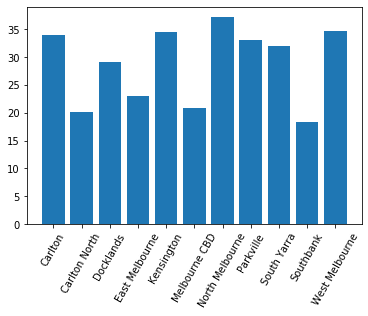

In [8]:
#3.1 a
suburb = traffic[['suburb', 'average_speed']]
suburb = suburb.set_index('suburb')
suburb = suburb.rename(index = {'CARLTON': 'Carlton'})
suburb = suburb.groupby(by = 'suburb')
suburb = suburb.mean()
sub_num = len(suburb)
suburb_names = suburb.index
plt.bar(arange(sub_num), suburb['average_speed'])
plt.xticks(arange(sub_num), suburb_names, rotation=60)

{'whiskers': [<matplotlib.lines.Line2D at 0x1f06984c9e8>,
 'caps': [<matplotlib.lines.Line2D at 0x1f0698496d8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f06984ce48>],
 'medians': [<matplotlib.lines.Line2D at 0x1f0698493c8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f0698490b8>],
 'means': []}

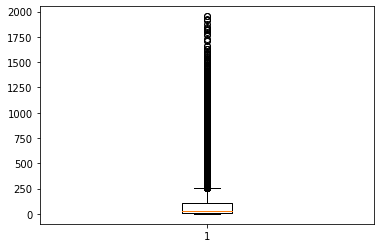

In [9]:
#Q 3.1 b
#plotting the box plot for vehical_class_1
#The plot describes that there are more small vehicles than expected, its skewed right, high outliers 
vehical_class_1 = traffic['vehicle_class_1']
plt.boxplot(vehicle_class_1)

No handles with labels found to put in legend.


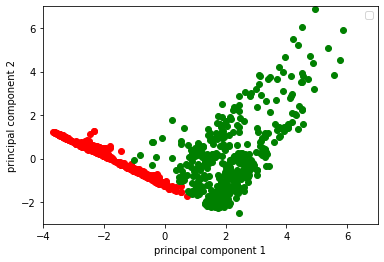

In [10]:
# Q 3.2a
special_traffic = pd.read_csv('special_traffic.csv', encoding = 'ISO-8859-1')
special_traffic = special_traffic.sample(n = 1000)
StrType = special_traffic
# getting the StrType 
StrType = StrType.reset_index()
StrType = StrType.drop(['index'], axis = 1)
#removing idx and StrType from special_traffic 
special_dataframe = special_traffic.iloc[:,1:19]
#normalizing the data using the formula
special_dataframe = ((special_dataframe - special_dataframe.min())/(special_dataframe.max() - special_dataframe.min()))*5
StrType = pd.DataFrame(StrType)


pca = PCA(n_components=2)
#finding the principal component of the data
principalComponents = pca.fit_transform(special_dataframe)
principalData = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
#taking the principal data without the StrType
principal_elbow = principalData.copy()
principalData['StrType'] = StrType['StrType']
council_minor = principalData.loc[principalData['StrType'] == 'Council Minor']
arterial = principalData.loc[principalData['StrType'] == 'Arterial']

#plotting the data 
plt.scatter(council_minor.loc[:,'principal component 1'], council_minor.loc[:,'principal component 2'], color = 'red')
plt.scatter(arterial.loc[:,'principal component 1'], arterial.loc[:,'principal component 2'], color = 'green')
plt.xlim(-4,7)
plt.ylim(-3,7)
plt.xlabel("principal component 1")
plt.ylabel("principal component 2")
plt.legend()
plt.show()
#The scatter plot shows principal components of the data which might be vehicle_class_1 and the average_speed

<function matplotlib.pyplot.show(*args, **kw)>

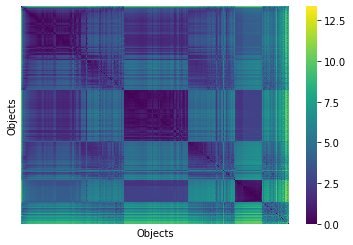

In [11]:
# 3.2 c
#finding the heat map for all features
RV, C, i = VAT(special_dataframe)
heat_map = sns.heatmap(RV, cmap="viridis", xticklabels=False,yticklabels = False)
heat_map.set(xlabel = 'Objects', ylabel = 'Objects')
plt.show
#3.2d There are basically 3 major clusters coming out of the heatmap showing closeness, identifying 2 principal components
#large one in middle and small clister in the bottom right corner 

<function matplotlib.pyplot.show(*args, **kw)>

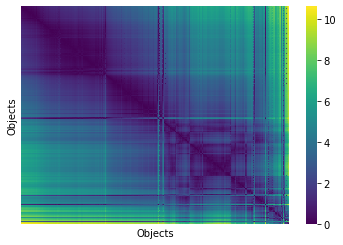

In [12]:
#finding the heat map for principal components
RV, C, i = VAT(principalComponents)
heat_map = sns.heatmap(RV, cmap="viridis", xticklabels=False,yticklabels = False)
heat_map.set(xlabel = 'Objects', ylabel = 'Objects')
plt.show
#3.2d This plot is basically signifying 3 major clusters of which 2 are more closely related to each other than the 3rd one
#The 2 clusters in the bottom right, which shiws even if there are 3 clusters, 2 clusters will be closely related to each 
#other

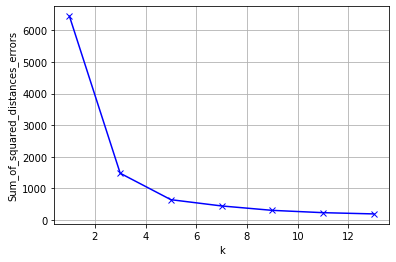

In [13]:
# Q3.3 a
#finding the sum of square  errors
Sum_of_squared_distances = []
K = range(1,14 ,2)
for k in K: 
    #going through the every cluster and findiing the clusters
    km = KMeans(n_clusters=k)
    km = km.fit(principal_elbow)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances_errors')
plt.grid(True)
plt.show()
# Yes it is giving expected result showcasing 3 clusters, We want the max variation with. The amount of variation between 
#clusters start to plateau, hence supporting our argument that 3 is the optimal amount of clusters 

([<matplotlib.axis.XTick at 0x1f0683325f8>,
 <a list of 3 Text xticklabel objects>)

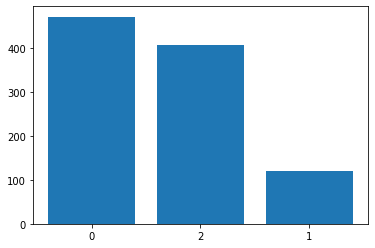

In [14]:
#Q 3.3b
from collections import Counter
#finding the number of elements in the cluster
df = principal_elbow
kmeans = KMeans(n_clusters=3).fit(df)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
#creating the dictionary for every cluster
dictionary_vals = Counter(labels)
dictionary_vals = dict(dictionary_vals)

plt.bar(range(len(dictionary_vals)), list(dictionary_vals.values()), align='center')
plt.xticks(range(len(dictionary_vals)), list(dictionary_vals.keys()))


No handles with labels found to put in legend.


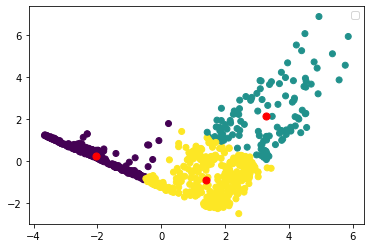

In [15]:
#3.3c Scatter plot is the best way to showcase , it uses the 2 principal components of the special_traffiv which have the
# highest dissimilarity, so the 3 clusters sould be well visible in a cluster plot 

#3.3d
plt.scatter(df['principal component 1'], df['principal component 2'], c= kmeans.labels_.astype(float))
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.legend()
plt.show()